# Convex Optimization - Homework 3 (Yui Chi HUNG)

## Problem 1: Deriving the dual problem of LASSO and formatting it as a general Quadratic Problem (QP)

Firstly, reformulate $\min_{w} \frac{1}{2}||Xw-y||_2^2+\lambda||w||_1$ as $\min_{w,z} \frac{1}{2}||z||_2^2+\lambda||w||_1$ with $Xw-z-y=0$.

Then, the Lagrangian is 
\begin{align*}
L(w,z,\nu) &=\frac{1}{2}||z||_2^2+\lambda||w||_1+\nu^T(Xw-z-y)\\
&=\frac{1}{2}||z||_2^2-\nu^T z+\nu^T Xw+\lambda||w||_1-\nu^Ty
\end{align*}

with $\nu\in\mathbb{R}^n$. Since the terms involving $w$ and $z$ are separable, we can minimize them separately when calculating the Lagrange dual function $g(\nu)=\inf_{w,z}L(w,z,\nu)$.

For $\inf_w \nu^T Xw+\lambda||w||_1$, if $||X^T\nu||_\infty > \lambda$, let $|(X^T\nu)_j|>\lambda$. By setting $w=-t\cdot\text{sign}((X^T\nu)_j)e_j$ with $e_j$ being the j-th basis vector in the canonical basis of $\mathbb{R}^d$, $\nu^T Xw+\lambda||w||_1=-t\lambda(|(X^T\nu)_j|-1)\to-\infty$ as $t\to\infty$. Hence we have $\inf_w \nu^T Xw+\lambda||w||_1=0$ if $||X^T\nu||_\infty \leq \lambda$ (by taking $w=0$) and $-\infty$ otherwise. This is because for $||X^T\nu||_\infty \leq \lambda$, $|\nu^T Xw|=|(X^T\nu)^Tw|\leq\lambda||w||_1$.

For $\inf_z \frac{1}{2}||z||_2^2-\nu^T z$, by taking derivative with respect to $z$ and setting it to be 0, we get $z-\nu=0$, which means $z=\nu$. Since the expression is a convex function, $z=\nu$ gives the infimum which equals to $-\frac{||\nu||_2^2}{2}$.

Hence, $g(\nu)=-\frac{||\nu||_2^2}{2}-\nu^T y$ if $||X^T \nu||_\infty\leq\lambda$ and $-\infty$ otherwise. So, the dual problem of LASSO is
\begin{align*}
\max_\nu g(\nu) &\iff \max_\nu -\frac{||\nu||_2^2}{2}-\nu^T y\text{ subject to }||X^T \nu||_\infty\leq\lambda\\
&\iff \min_\nu \frac{||\nu||_2^2}{2}+y^T \nu\text{ subject to }||X^T \nu||_\infty\leq\lambda\\
&\iff \min_v v^TQv+p^Tv\text{ subject to }Av\preceq b
\end{align*}

with $v=\nu\in\mathbb{R}^n$, $Q=\frac{1}{2}I_{n\times n}$, $p=y\in\mathbb{R}^n$, $A=\begin{bmatrix}X^T\\-X^T\end{bmatrix}\in\mathbb{R}^{2d\times n}$, and $b$ is a vector in $\mathbb{R}^{2d}$ with all its elements as $\lambda$.

## Problem 2: Implementation of the barrier method to solve QP

Firstly, consider the central path minimization problem corresponing to the above-mentioned QP. It is $\min_v f(v)=\min_v tf_0(v)+\phi(v)$ with $t>0$, $f_0(v)=v^TQv+p^Tv$ and $\phi(v)=-\sum_{i=1}^{2d} \log(b_i-A^{(i)}v)$, with $A^{(i)}$ denoting the $i$-th row of $A$.

Now, we calculate the gradient and the Hessian of $f(v)$ for the Newton's method by chain rule.
\begin{align*}
\nabla f(v) &= t(2Qv+p) +\sum_{i=1}^{2d} \frac{1}{b_i-A^{(i)}v} {A^{(i)}}^T\\
\nabla^2 f(v) &= 2tQ +\sum_{i=1}^{2d} \left(\frac{1}{b_i-A^{(i)}v}\right)^2 {A^{(i)}}^T A^{(i)}
\end{align*}

With the formulas, we can now implement the functions *centering_step$(Q,p,A,b,t,v0,eps)$*, *barr_method$(Q,p,A,b,v0,eps)$*, and the functions that are used in *centering_step* and *barr_method*.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def s_feasible(A,b,v):
    # check if the input A,b,v strictly satisfy the constraint
    return ((np.matmul(A,v) >= b).sum() == 0)

In [3]:
def f0(Q,p,v):
    return np.matmul(v.T, np.matmul(Q,v)) + np.dot(p,v)

In [4]:
def f(Q,p,A,b,t,v):
    f0 = np.matmul(v.T, np.matmul(Q,v)) + np.dot(p,v)
    phi = -np.sum(np.log(b-np.matmul(A,v)))
    return t*f0+phi

In [5]:
def backtracking(Q,p,A,b,t,v,alpha,beta,grad,newton_step):
    bt = 1
    too_small = False
    while True:
        if not s_feasible(A,b,v+bt*newton_step):
            bt *= beta
        elif bt < 1e-10:
            too_small = True
            break
        elif f(Q,p,A,b,t,v+bt*newton_step) > f(Q,p,A,b,t,v)+alpha*bt*np.dot(grad,newton_step):
            bt *= beta
        else:
            break
    return bt, too_small

In the implmentation of the sub-routine *centering_step*, a use of the tensor structure to store ${A^{(i)}}^T A^{(i)}$ for each $i$ is more convenient to compute the Hessian. Other values such as $\frac{1}{b_i-A^{(i)}v}$'s are also pre-computed to improve the running time.

The function does not return the sequence of variables iterates $(v_i)_{i=1,...}$ because I feel like it is more useful to only include that in the barrier method iteration. If it is necessary, this can be done simply by creating a list to store the values at each iteration (see the implementation of *barr_method* for details).

In [6]:
def centering_step(Q,p,A,b,t,v0,eps):
    v = v0
    iter = 0
    bAv_inv = 1/(b-np.matmul(A,v))
    ATA_tensor = np.zeros((A.shape[0], A.shape[1], A.shape[1]))
    for i in range(A.shape[0]):
        ATA_tensor[i,:,:] = np.matmul(A[i,:].T, A[i,:])
    while True:
        # compute the Newton step and decrement
        grad = t*(2*np.matmul(Q,v)+p) + np.dot(A.T, bAv_inv)
        hess = 2*t*Q + np.tensordot(bAv_inv**2,ATA_tensor,1)
        newton_step = -np.matmul(np.linalg.inv(hess), grad)
        newton_decrement_sq = np.dot(grad,-newton_step)
        
        # stopping criterion
        if newton_decrement_sq <= eps:
            break
        
        # backtracking line search (and stopping criterion for backtracking)
        alpha = 0.1 # parameter of backtracking
        beta = 0.5 # parameter of backtracking
        bt, too_small = backtracking(Q,p,A,b,t,v,alpha,beta,grad,newton_step)
        if too_small:
            break
        
        # update
        v += bt*newton_step
        iter += 1
    return v

In [7]:
def barr_method(Q,p,A,b,v0,t=0.1,mu=1.5,eps=1e-5): # t > 0, mu > 1, eps > 0
    v_list = []
    f0_list = []
    v = v0
    iter = 1
    while True:
        # centering step and update
        v = centering_step(Q,p,A,b,t,v0,eps)
        v_list.append(v)
        f0_list.append(f0(Q,p,v))
        
        # stopping criterion and increase t
        m = A.shape[0]
        if m/t < eps:
            break
        t *= mu
        iter += 1
    return v_list, f0_list

## Problem 3: Testing the implemented functions on randomly generated data, and a comparison on different values of $\mu$

In this section, $X$ and $y$ are generated randomly by a linear relationship using a hidden feature vector $w$. The setting has $n<d$, which is a proper situation to consider LASSO. The initialization $v_0$ is taken to be a zero vector because it must be feasible in our case. For testing of the functions implemented above, I have also included a toy example on the data generation. The retrieved $w$ should be very close to the underlying $w$ if $λ$ is small enough. However, some numerical issues may happen if $\lambda=0$ in my implementation.

The way to calculate the gap $f(v_t)-f^*$ is implemented in the post-processing part.

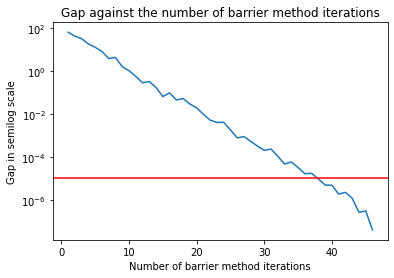

In [8]:
_lambda = 10
# data generation
# test: w = [3,-2]
# X = np.array([[1,1],[0.5,-2],[3,0],[-2,1],[-1,5]])
# y = Xw = np.array([1,5.5,9,-8,-13])

n = 10 # number of data points
d = 60 # number of features
X = np.random.randn(n,d) # data vectors
w = np.random.randn(d)
y = np.matmul(X,w) # observations

# setting parameters for using the barrier method
Q = 0.5*np.eye(n)
p = y
A = np.concatenate((X.T,-X.T), axis=0)
b = _lambda*np.ones(2*d)
# print(A.shape,b.shape)

# initialization and hyperparameter tuning
v0 = np.zeros(n)
# t = 
# mu = 
eps = 1e-5

# running the barrier method
assert s_feasible(A,b,v0)
v_list, f0_list = barr_method(Q,p,A,b,v0,eps=eps)

# postprocessing
v_ast = v_list.pop(-1)
f0_ast = f0_list.pop(-1)
gap_list = f0_list - f0_ast
iter = list(range(len(gap_list)+1))
iter.pop(0)

# graph plotting
plt.semilogy(iter,gap_list)
plt.axhline(y=eps,color='r') # epsilon precision criterion
plt.xlabel('Number of barrier method iterations')
plt.ylabel('Gap in semilog scale')
plt.title('Gap against the number of barrier method iterations')
plt.show()

To recover $w$, take $v^*$ ($\nu^*$) to be the dual optimal solution. The next step is to minimize $L(x,z,\nu^*)=\frac{1}{2}||z||_2^2-{\nu^*}^T z+{\nu^*}^T Xw+\lambda||w||_1-{\nu^*}^Ty$.

Minimizing over $w$: since the terms involving $w$ can be separated by its coordinates, the optimization can be done by coordinate. If $|(X^T\nu^*)_i|<\lambda$, $w_i=0$ minimizes the terms involving $w$ since $(|(X^T\nu^*)_i|+\lambda)w_i>0$ unless $w_i=0$.

Minimizing over $z$ (solve non-zero $w_i$'s): let $X'$ as the sub-matrix of $X$ containing the columns $i$ if $w_i\neq0$, and $w'$ as the vector removing all $w_i\neq0$ from $w$. Taking derivative of $L(x,z,\nu^*)$ with respect to $z$ and setting the derivative as zero gives $z=\nu^*$. Using $z=Xw-y$ and consider the coordinates of $w$ with $w_i=0$, $X'w'=y+\nu^*$ is obtained. The solution is $w'=(X'^T X')^{-1}X'^T(y+\nu^*)$.

Combining the two results give the formula for recovering $w$. The following code implements the analytical solution.

The value of w for mu=2 
 [0.         0.         0.         0.         0.         3.40318548
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
The value of w for mu=5 
 [0.         0.         0.         0.         0.         3.40318548
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.  

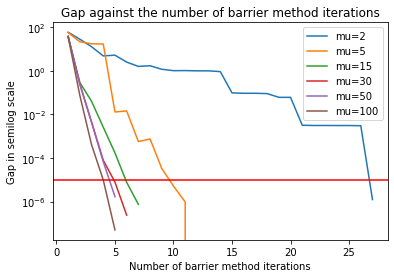

In [9]:
def w(X,y,v,_lambda):
    w = np.zeros(d)
    w_nonzero = (abs(np.matmul(X.T,v_ast)) + 1e-5 > _lambda) # add a small value to avoid numerical issues
    Xp = X[:,np.where(w_nonzero)[0]]
    w[np.where(w_nonzero)[0]] = np.matmul(np.linalg.inv(np.matmul(Xp.T,Xp)),np.matmul(Xp.T,(y+v)))
    return w

w_list = []
mu_list = [2,5,15,30,50,100]
for mu in mu_list:
    v0 = np.zeros(n)
    v_list, f0_list = barr_method(Q,p,A,b,v0,mu=mu,eps=eps)
    v_ast = v_list.pop(-1) 
    w_list.append(w(X,y,v_ast,_lambda))

    f0_ast = f0_list.pop(-1)
    gap_list = f0_list - f0_ast
    iter = list(range(len(gap_list)+1))
    iter.pop(0)
    plt.semilogy(iter,gap_list,label="mu=%d"%mu)

for i in range(len(w_list)):
    print("The value of w for mu=%d" %mu_list[i], "\n", w_list[i])

plt.axhline(y=eps,color='r') # epsilon precision criterion
plt.xlabel('Number of barrier method iterations')
plt.ylabel('Gap in semilog scale')
plt.title('Gap against the number of barrier method iterations')
plt.legend()
plt.show()

In general, a change in the value of $\mu$ does not affect the value of $w$ obtained. Sometimes, a smaller value of $\mu$ will generate a solution with more non-zero entries, but it is not very common to obtain this result (this can be more often to occur if $\lambda$ is set to be smaller or $\mu$ is very close to 1, but I am not sure).

Based on the result that $w$ is unchanged with respect to the value of $\mu$, a larger value of $\mu$ is suggested because it will then take fewer iterations of the barrier method to obtain $w$. This increases the efficiency of running the barrier method.